In [135]:
from utilsGeneral import UtilsGeneral
from utilsModel import UtilsModel
from utilsPlot import UtilsPlot
from KnapSack import KnapSack
from shallowNet.shallowNet import shallowNet, DenseTranspose
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import transforms
import math
import scipy.stats as stats
import collections
import matplotlib.cm as cm
import tensorflow as tf
import matplotlib.gridspec as gridspec
from numpy.ma import masked_array
from matplotlib import pyplot, transforms





In [38]:
knapSack = KnapSack("100_5_25_1")
utg = UtilsGeneral(knapSack)
utm = UtilsModel(utg)
utp = UtilsPlot(utilsGeneral = utg, utilsModel = utm)
fitness_function = knapSack.Fitness

Best Objective Value: 0


In [377]:
#tmptrain = utg.generate_training_set(100, 100)
tmptrain = utg.load_datasets(1)

In [379]:
#utg.save(tmptrain)
np.shape(tmptrain)

(1, 10, 100)

In [41]:
set1 = utg.load_datasets(1)
model1, model2, model3, model4, model5, model6= utg.load_models(1,2, 3,4,5,6)

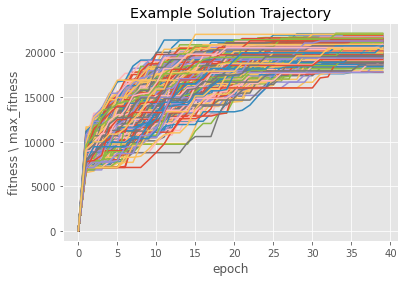

In [190]:
max_fitness, final_solutions = utp.plot_trajectory_evolution(100, learning_steps = 40, sample_number=600, model = model2)

In [42]:
def TrainToSol(sol):
    ConvertSol = np.copy(sol)
    ConvertSol[sol == -1] = 0
    return ConvertSol

def SolDistribution(sol):
    size = np.shape(sol)[-1]
    arr = np.zeros(size)
    for i in sol:
        arr += TrainToSol(i)
    return arr/ np.shape(sol)[0]



def che(sol):
    arr = SolDistribution(sol)
    return AverageElements(arr)

In [43]:
def plot_distribution(sol, title = "Independent probability distribution", xl = "Bit position", yl ="Probability"):
    plt.figure()
    plt.title(title)
    plt.bar(np.arange(len(sol)), sol, align = "center", alpha = 0.5)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

In [44]:
def partition(array, numbers_of_partition=2, lambda_cof=1, mean= None, std = None):
    def get_index_list(array, element):
        return [i for i, e in enumerate(array) if e == element]
    if type(array) != type([1,2]):
        array = array.tolist()
    if std == None:
        std = np.std(array)
    if mean == None:
        mean = np.sum(array)/np.shape(array)[0] ### idk why np.mean(...) does not work 
    arraycopy = copy.copy(array)
    res = []
    mapindex = {}
    stop = False
    for i in range(1,numbers_of_partition+1): 
        tmp_left = []
        tmp_right = []
        array_len = len(arraycopy)
        for j in range(array_len):
            element = arraycopy.pop(0)
            if mapindex.get(element) == None:
                    mapindex[element] = get_index_list(array, element)
            if i == numbers_of_partition:
                if element < mean:
                    tmp_left.append(mapindex[element].pop())
                else:
                    tmp_right.append(mapindex[element].pop())
            else:
                if element >= mean - i * std/lambda_cof and element <= mean:
                    tmp_left.append(mapindex[element].pop())
                    
                elif element >= mean and element <= mean + i * std/lambda_cof:
                    tmp_right.append(mapindex[element].pop())
                else:
                    arraycopy.append(element)
                
        res.insert(0, np.asarray(tmp_left))
        res.append(np.asarray(tmp_right))

    return res, mean, std

In [45]:
def choose_group():
    p = [0.2, 0.3, 0.3, 0.2]
    r = np.random.choice(np.arange(len(p)),1, p=p)[0]
    x = np.random.choice(np.arange(2),1, p = [0.2, 0.8])[0]
    length = len(p)
    if r+x>length-1:
        x-=1
    return r, r+x

def flip(solution, index_one, index_two):
    solution[index_one] *= -1
    solution[index_two] *= -1
    return

def search_function(array, par, choosing_group_function = None, debuge_variation=False):
    if choosing_group_function == None:
        choosing_group_function = choose_group
    i_one, i_two = choosing_group_function()
    par = par[0]

    group_one = par[i_one]
    group_two = par[i_two]

    if len(group_one) == 0 or len(group_two) == 0:
        utg.flip(array, 100)
        return
    index_one = np.random.randint(len(group_one))
    index_two = np.random.randint(len(group_two))

    if not debuge_variation:
        flip(array, group_one[index_one], group_two[index_two])
    else:
        print(array)
        print(i_one, ", ", i_two, " partition shape: ", np.shape(par))
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
        flip(array, group_one[index_one], group_two[index_two])
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
    

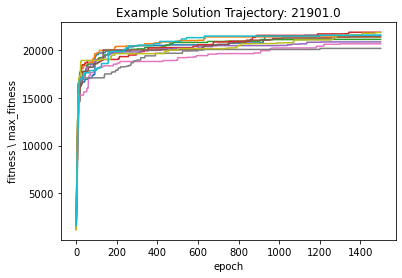

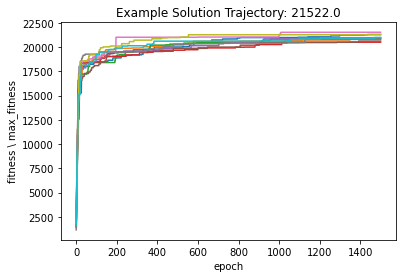

In [392]:
def plot_trajectory(sample_size, search = None, sample_number=10, learning_steps=100, transfer_step = 50, model=None, debuge_variation=False):
    global_solution = []
    par = []
    current_solutions_container = [utg.initialize_solution(sample_size) for i in range(sample_number)]
    max_fitness = 0
    for i in range(learning_steps):
        if i <transfer_step -1: 
            search = utg.flip
        else:
            if i % (transfer_step -1) == 0:
                par = partition(knapSack.P, numbers_of_partition=2, lambda_cof=1)    
        tmp_his = []
        for j in range(sample_number):
            copy_solution = copy.copy(current_solutions_container[j])
            if i > (transfer_step -1): 
                search_function(copy_solution, par = par, choosing_group_function = choose_group, debuge_variation = False)
            else:
                utg.flip(copy_solution, sample_size)
            current_fitness = fitness_function(current_solutions_container[j])
            new_fitness = fitness_function(copy_solution)
            if new_fitness > current_fitness:
                current_solutions_container[j] = copy_solution
                current_fitness = new_fitness
            tmp_his.append(current_fitness)
            if current_fitness >= max_fitness:
               max_fitness =current_fitness
            


        global_solution.append(np.asarray(tmp_his))
    global_solution = np.asarray(global_solution)
    plt.figure()
    plt.title("Example Solution Trajectory: {}".format(max_fitness))
    X = np.arange(learning_steps)
    for j in range(sample_number):
        plt.plot(X, global_solution[:,j])
    plt.xlabel("epoch")
    plt.ylabel("fitness \ max_fitness")
    plt.show()
        
    return global_solution, par
glob1, par1 = plot_trajectory(100, learning_steps= 500, transfer_step = 100)
_ =plot_trajectory(100, learning_steps= 500, transfer_step = 2000)


In [48]:
def code(array, encoder, input_size=None, latent_size=None, debuge_variation=False):
    if input_size == None:
        input_size = len(array) # if input_size is implicit do not waist time to calcule it
    if latent_size == None:
        latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1] # if latent_size is implicit do not waist time to calcule it
    encoded_solution = encoder(np.expand_dims(array, axis = 0)).numpy().flatten() # encode array 
    return encoded_solution

def decod(encoded_solution, decoder, latent_size, output_size):
    new_tensor = decoder(encoded_solution.reshape(1,latent_size)) # decode changed solution 
    output_array_binary = np.where(new_tensor.numpy()[-1] > 0.0, 1, -1)  # binarize decoded tensor around 0.0
    new_fitness = fitness_function(output_array_binary) # calculate new fitness
    return output_array_binary, new_fitness

In [255]:
def weights_matrix_sorting(model, activation=1, background_activation = -1, column_sort = True, unit_sort=True, index_sort = False, log_conversion = False):
    
    def value(x):
        if log_conversion:
            return round(math.log(x,10))
        else:
       
            return x

    def shuffle_columns_weights_matrix(decoder, pos): 
        matrix  = decoder.layers[1].get_weights()[1]
        mat = np.full_like(matrix, 0)
        index = 0
        for i in pos:
            mat[:, index] = matrix[:, i]
            index +=1
        return mat

    def matrix_row_sort(x):
        def pushZerosToEnd(arr): 
            count = 0 # Count of non-zero elements 
            n = len(arr)
            for i in range(n): 
                if arr[i] != 0: 
                    arr[count] = arr[i] 
                    count+=1
            while count < n: 
                arr[count] = 0
                count += 1
            return arr
        
        def pushZerosToBegining(arr): 
            count = 0 # Count of non-zero elements 
            tmp = []
            count_zeros =0
            for i in arr.tolist(): 
                if i != 0: 
                    tmp.append(i)
                else:
                    count_zeros+=1
            return np.concatenate((np.zeros(count_zeros), np.asarray(tmp)), axis = None)

        pos = []
        neg = []

        if unit_sort:
            for i in x:
                if i>0:
                    pos.append(value(i))
                else:
                    pos.append(value(-i))
            return np.sort(pos)

        else:
            for i in x:
                if i>0:
                    pos.append(value(i)) 
                    neg.append(0)
                else:
                    neg.append(value(-i))
                    pos.append(0)
            return pushZerosToEnd(-np.sort(-np.asarray(neg)[::-1])), pushZerosToBegining(np.sort(np.asarray(pos)))            
        
        
    encoder, decoder = utm.split_model_into_encoder_decoder(model)
    size = encoder.layers[0].input_shape[0][-1]
    latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1]
    res = np.zeros(latent_size)
    glob_pos = {}
    for i in range(size):
        arr = np.zeros(size) + background_activation
        arr[i] = activation
        res += np.where(code(arr, encoder) > 0.0, 0, 1)/size
    
    for i in range(latent_size):
        glob_pos[i] = res[i]

    if index_sort:
        pos = {k : v for k, v in sorted(glob_pos.items(), key = lambda item : item[1])}
        res.sort() # sort bits accorg
    else:
        pos = np.arange(latent_size)

    if column_sort:        
        weights_matrix = shuffle_columns_weights_matrix(decoder, pos).transpose()
    else:
        weights_matrix = shuffle_columns_weights_matrix(decoder, pos)        

    if unit_sort:
        sorted_weights_matrix = copy.copy(weights_matrix)
        for i in range(np.shape(sorted_weights_matrix)[0]):
            sorted_weights_matrix[i] = matrix_row_sort(sorted_weights_matrix[i])
        if column_sort:
            weights_matrix = weights_matrix.transpose()
            sorted_weights_matrix = sorted_weights_matrix.transpose()

        return res, weights_matrix, sorted_weights_matrix

    else:
        sorted_weights_matrix_neg = copy.copy(weights_matrix)
        sorted_weights_matrix_pos = copy.copy(weights_matrix)

        for i in range(np.shape(sorted_weights_matrix_pos)[0]):
            sorted_weights_matrix_neg[i], sorted_weights_matrix_pos[i] = matrix_row_sort(sorted_weights_matrix_neg[i])

        if column_sort:
            weights_matrix =weights_matrix.transpose()
            neg_mask = masked_array(sorted_weights_matrix_neg.transpose(), sorted_weights_matrix_neg.transpose()==0)
            pos_mask = masked_array(sorted_weights_matrix_pos.transpose(), sorted_weights_matrix_pos.transpose()==0)
        else: 
            neg_mask = masked_array(sorted_weights_matrix_neg, sorted_weights_matrix_neg==0)
            pos_mask = masked_array(sorted_weights_matrix_pos, sorted_weights_matrix_pos==0)

        return res, weights_matrix, neg_mask, pos_mask ,sorted_weights_matrix_neg, sorted_weights_matrix_pos

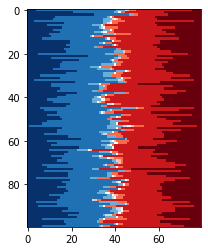

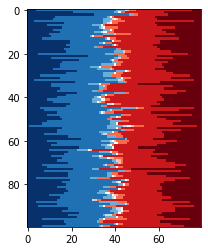

In [393]:
bit_activation, weights_matrix, neg_mask,pos_mask,_,_  = weights_matrix_sorting(model3, activation=1, background_activation =-1, column_sort = False, unit_sort=False, index_sort = False, log_conversion = True)
plt.figure()
plt.imshow(neg_mask,interpolation='nearest',cmap=cm.Blues)
plt.imshow(pos_mask,interpolation='nearest',cmap=cm.Reds)
bit_activation, weights_matrix, neg_mask,pos_mask,_,_  = weights_matrix_sorting(model3, activation=1, background_activation =-1, column_sort = False,unit_sort=False, index_sort = False, log_conversion = True)
plt.figure()
plt.imshow(neg_mask,interpolation='nearest',cmap=cm.Blues)
plt.imshow(pos_mask,interpolation='nearest',cmap=cm.Reds)

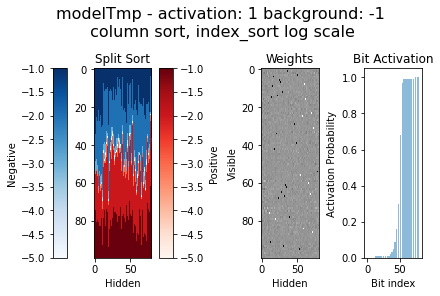

In [267]:
def latent_activation(model, title, activation=1, background_activation =-1, column_sort = True, unit_sort=True, index_sort = False, log_conversion = True):
    bit_activation, weights_matrix, *masks  = weights_matrix_sorting(model, activation, background_activation,column_sort = column_sort, unit_sort = unit_sort, index_sort = index_sort, log_conversion = log_conversion)

    title = title + " - activation: " +str(activation)+" background: "+ str(background_activation) + "\n "
    if column_sort:
        title += "column sort, "
    else:
        title += "row sort, "
    if index_sort:
        title += "index_sort"
    else:
        title += "no index sort"
    if log_conversion:
        title += " log scale"
    else:
        title += " linear scale"
    
    if index_sort:
        fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout = True)
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
    fig.suptitle(title, fontsize=16)
    if unit_sort:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Greys_r)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        cba.set_label('Magnitude of Absolute Activation')
        axes[0].set_title("Unit Sort")
        axes[0].set_xlabel("Hidden")
    else:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Blues)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        pb = axes[0].imshow(masks[1],interpolation='nearest',cmap=cm.Reds)
        cbb = fig.colorbar(pb, ax = axes[0], location = "right")
        cba.set_label('Negative')
        cbb.set_label('Positive')
        axes[0].set_title("Split Sort")
        axes[0].set_xlabel("Hidden")
    axes[0].set_aspect('auto')

    
    axes[1].imshow(weights_matrix, interpolation='nearest', cmap=cm.Greys_r)
    axes[1].set_title("Weights")
    axes[1].set_ylabel("Visible")
    axes[1].set_xlabel("Hidden")
    axes[1].set_aspect('auto')
    
    if index_sort:
        axes[2].bar(np.arange(len(bit_activation)), bit_activation, align = "center", alpha = 0.5)
        axes[2].set_title("Bit Activation")
        axes[2].set_ylabel("Activation Probability")
        axes[2].set_xlabel("Bit index")
        axes[2].set_aspect('auto')
    return
latent_activation(model3, "modelTmp", background_activation=-1, unit_sort = False, index_sort=True, column_sort=True, log_conversion = True)

In [228]:
bit_activation, weights_matrix, *masks  = weights_matrix_sorting(model, activation, background_activation,column_sort = True, unit_sort = True, index_sort = False)

In [230]:
masks[0]

array([[-4., -4., -4., ..., -3., -4., -5.],
       [-3., -4., -4., ..., -3., -4., -4.],
       [-3., -4., -3., ..., -3., -4., -4.],
       ...,
       [-1., -1., -1., ..., -1., -2., -1.],
       [-1., -1., -1., ..., -1., -2., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

Text(0.5, 1.0, 'Weights Matrix')

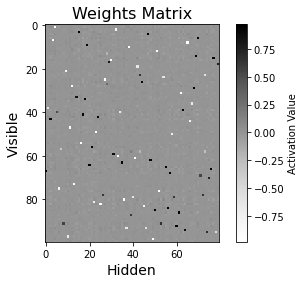

In [51]:
im = plt.imshow(utm.split_model_into_encoder_decoder(model2)[1].layers[1].get_weights()[1], interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Activation Value')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix", fontsize=16)

Text(0.5, 1.0, 'Weights Distribution for Single Row')

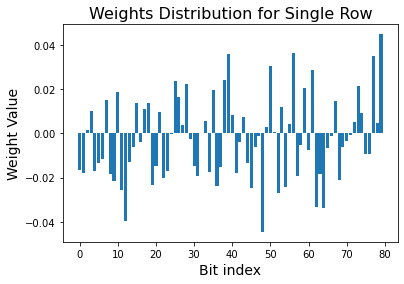

In [52]:
plt.figure()
plt.bar(np.arange(len(bit_activation)), weights_matrix[0])
plt.xlabel("Bit index", fontsize =14)
plt.ylabel("Weight Value", fontsize=14)
plt.title("Weights Distribution for Single Row", fontsize=16)

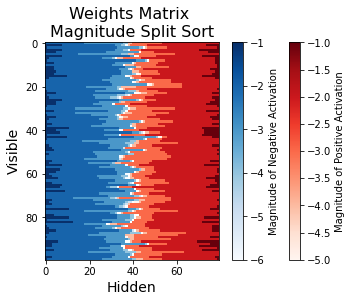

Text(0.5, 1.0, 'Weights Matrix Sorted')

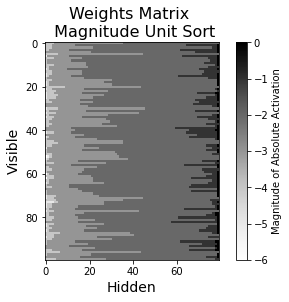

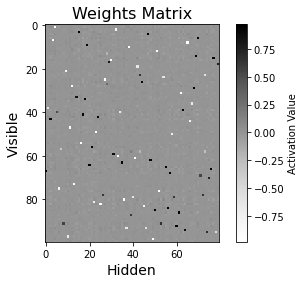

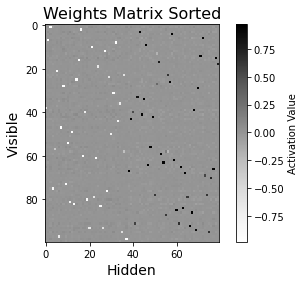

In [53]:
model = model2
res, weights_matrix, neg_mask, pos_mask ,_,_  = weights_matrix_sorting(model, activation=1, background_activation =-1, weight_sort="split")
def plot_magnitude_weight(mask_neg, mask_pos):    
    v1a = mask_pos
    v1b = mask_neg
    fig,ax = plt.subplots()
    pa = ax.imshow(v1a,interpolation='nearest',cmap=cm.Reds)
    cba = plt.colorbar(pa)
    pb = ax.imshow(v1b,interpolation='nearest',cmap=cm.Blues)
    cbb = plt.colorbar(pb)
    plt.xlabel('Hidden', fontsize=14)
    plt.ylabel('Visible', fontsize=14)
    plt.title("Weights Matrix \nMagnitude Split Sort", fontsize=16)
    cba.set_label('Magnitude of Positive Activation')
    cbb.set_label('Magnitude of Negative Activation')
    plt.show()    
plot_magnitude_weight(neg_mask, pos_mask)

bit_activation, weights_matrix, sorted_weights_matrix  = weights_matrix_sorting(model, activation=1, background_activation =-1, weight_sort="unit")
plt.figure()
im = plt.imshow(sorted_weights_matrix, interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Magnitude of Absolute Activation')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix \n Magnitude Unit Sort", fontsize=16)

plt.figure()
im = plt.imshow(utm.split_model_into_encoder_decoder(model)[1].layers[1].get_weights()[1], interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Activation Value')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix", fontsize=16)

plt.figure()
im = plt.imshow(weights_matrix, interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Activation Value')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix Sorted", fontsize=16)

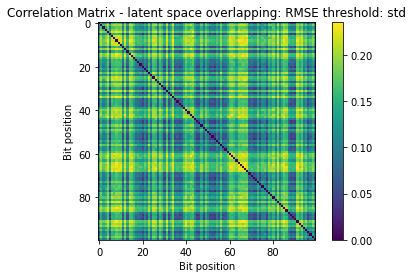

In [290]:
def correlation_matrix(model, activation=1, background_activation =-1, threshold = None):
    def latent_activation(model):
        encoder, decoder = utm.split_model_into_encoder_decoder(model)
        size = encoder.layers[0].input_shape[0][-1]
        res = []
        for i in range(size):
            arr = np.zeros(size) + background_activation
            arr[i] = activation
            res.append(code(arr, encoder))
        return res

    def correlation(array1, array2, threshold = threshold):
        arr = array1-array2
        if threshold == None:
            threshold = np.std(arr)
        arr=np.where(((arr < threshold) & (arr > -threshold)), 0, arr)
        return np.sqrt((arr**2).mean())
  
   

    encoded_bit_representation =latent_activation(model)
    sample_numbers = np.shape(encoded_bit_representation)[0]
    conv = []
    for i in range(sample_numbers):
        tmp = []
        for j in range(sample_numbers):
            tmp.append(
                correlation(
                    encoded_bit_representation[i], 
                    encoded_bit_representation[j]
                    ))
        conv.append(np.asarray(tmp))
    return np.asarray(conv)

def plot_correlation_matrix(model, activation=1, background_activation =-1, threshold = None):
    plt.figure()
    res =correlation_matrix(model, activation=activation, background_activation = background_activation, threshold = threshold)
    plt.imshow(res, interpolation='nearest')
    if threshold==None:
        threshold = "std"
    plt.title("Correlation Matrix - latent space overlapping: RMSE threshold: {}".format(threshold))
    plt.xlabel("Bit position")
    plt.ylabel("Bit position")
    plt.colorbar()

plot_correlation_matrix(model3, background_activation=-1, threshold = None)
#plot_correlation_matrix(model4, background_activation=-1)
#plot_correlation_matrix(model5, background_activation=-1)
#plot_correlation_matrix(model6, background_activation=-1)



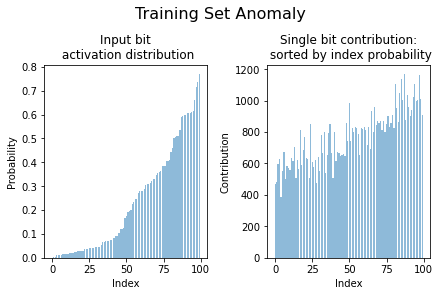

In [13]:
def plot_set_probability_and_values(set_):
    sample_size = np.shape(set_)[-1]
    arr = np.zeros(sample_size)
    set_size = np.shape(set_)[0]
    glob = {}
    index = 0
    for i in set_:
        arr +=np.where(i<0,0,1)
        
    arr = arr/set_size

    for i in range(len(arr)):
        glob[i] = arr[index]
        index +=1

    arr.sort()
    pos = {k : v for k, v in sorted(glob.items(), key = lambda item : item[1])}
    arr2 = []
    for i in pos:
        tmp = np.zeros(100)
        tmp[i] = 1
        arr2.append(np.dot(knapSack.P, tmp))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
    fig.suptitle('Training Set Anomaly', fontsize=16)
    axes[0].bar(np.arange(sample_size), arr, alpha = 0.5)
    axes[0].set_title("Input bit\n activation distribution")
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel("Index")
    axes[1].bar(np.arange(sample_size), arr2, alpha = 0.5) 
    axes[1].set_title("Single bit contribution:\n sorted by index probability")
    axes[1].set_ylabel("Contribution")
    axes[1].set_xlabel("Index")
    plt.show()
    return
    
plot_set_probability_and_values(tmptrain)


In [14]:
def plot_latent_activation_distribution(set_, model, probability = False, sort = False, show = True, model_name = "", plot_name = None):
    def AllPositivesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return  np.where(sol > 0.0, 1, 0)
        ConvertSol[sol >= 0] = 0
        return ConvertSol
    def AllNegativesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return np.where(sol > 0.0, 0, 1)
        ConvertSol[sol < 0] = 0
        return ConvertSol

    e, d= utm.split_model_into_encoder_decoder(model)
    res_pos = []
    res_neg = []
    latent_size = np.shape(e.layers[-1].get_weights()[0])[-1]
    final_pos = np.zeros(latent_size)
    final_neg = np.zeros(latent_size)
    for i in set_:
        res_pos.append(AllNegativesToZero(code(i,e)))
        res_neg.append(AllPositivesToZero(code(i,e)))
    for i in res_pos:
        final_pos += i
    for i in res_neg:
        final_neg += i

    final_pos = final_pos/len(set_)
    if probability:
        final_neg = final_neg/len(set_) 
    else: 
        final_neg = final_neg/len(set_) *(-1)

    if sort: 
        final_neg.sort()
        final_pos[::-1].sort()

    partition_, mean, std = partition(final_pos, numbers_of_partition=2)
    partition_size = len(partition_)
    std_lines = []
    set_lines = []
    for arr in partition_:
        set_lines.append(arr[-1])
    set_lines.pop(0)

    for i in range(1,int(partition_size/2)):
        std_lines.append(i*std + mean)
        std_lines.append(-i*std + mean)


    plt.figure()
    if probability:
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        plt.bar(np.arange(len(final_pos)),-final_pos, color='blue', alpha = 0.7, label = "+p",transform = rot + base)
        plt.bar(range(len(final_neg)), -final_neg, bottom = -np.array(final_pos), color = "red", alpha = 0.7, label = "-p", transform = rot + base)
        #plt.gca().invert_xaxis()
        if sort:
            for xc in std_lines:
                plt.axvline(x = xc , color ="black", linestyle = '--')
            plt.axvline(x = mean, color = "black", linestyle = '--')
            for yc in set_lines: 
                plt.axhline(y = yc, color = "black", linestyle = '-')
            plt.title("+/-probability distributioin {}: stacked + sorted".format(model_name))
        else:
            plt.title("+/-probability distributioin {}: stacked".format(model_name))
        plt.xlabel("Probability")
        plt.ylabel("Bit positions")
        plt.legend()
    else:
        plt.bar(np.arange(len(final_pos)),final_pos,label = "Positive values", alpha = 0.5, color = "red")
        plt.bar(np.arange(len(final_neg)),final_neg, label = "Negative values * (-1)", alpha = 0.5, color = "blue")
        plt.title("+/- average bit values distributioin {}:".format(model_name))
        plt.ylabel("Average Value")
        plt.xlabel("Bit positions")
        plt.legend()
    if plot_name != None:
        path = utg.create_plot_path(plot_name)
        plt.savefig(path)
    return final_pos, final_neg, partition_

In [15]:
_ = plot_latent_activation_distribution(tmptrain, modelTmp, probability = True, sort = True, model_name = "modelTmp")


NameError: name 'modelTmp' is not defined

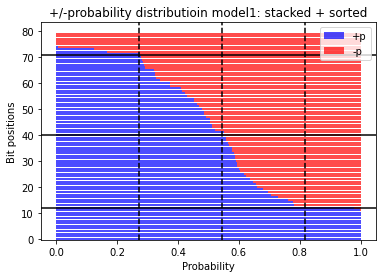

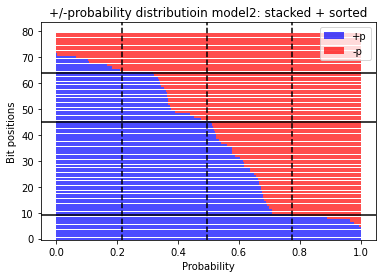

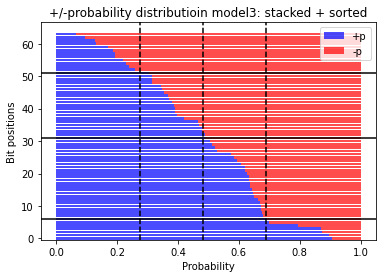

In [23]:
_ = plot_latent_activation_distribution(final_solutions, model1, probability = True, sort = True, model_name = "model1")
_ =plot_latent_activation_distribution(final_solutions, model2, probability = True, sort = True, model_name = "model2")
fp, fn, par  =plot_latent_activation_distribution(final_solutions, model3, probability = True, sort = True, model_name = "model3")
#fp, fn = plot_latent_activation_distribution(final_solutions, model3, probability = True, show= False, model_name = "model3")

In [ ]:
def plot_histogram_value_contribution(model, activation_value = (1)):

    e, d= utm.split_model_into_encoder_decoder(model)
    size = np.shape(e.layers[-1].get_weights()[0])[-1]
    for activation in activation_value:
        
        result = []
        for i in range(size):
            tmp = np.zeros(size)
            tmp[i] = activation
            result.append(decod(tmp, d, size, knapSack.Size)[-1])
        result = np.asarray(result)
        plt.hist(result, bins = 100,  density=True, histtype='bar', stacked=True, alpha =0.5, label = "Activation: {}".format(activation))
    plt.legend()
    plt.title("Single bit's contribution distribution in latent space")
    plt.xlabel("Single bit contribution")
    axes = plt.gca()
    axes.set_xlim([14000,21000])
    plt.show()

plot_histogram_value_contribution(model3, (-0.0,0.0))
plot_histogram_value_contribution(model3, (-0.6,0.6))
plot_histogram_value_contribution(model3, (0.4,0.6,0.8))

In [46]:
compression = 0.8
epochs = 500
batch_size = 20
reg_cof = (0.0001,0.001)
dropout = 0.2
lr = 0.001

def train_model(trainingSet, epochs = 500, compression = 0.8,  batch_size = 10, reg_cof = (0.0001,0.001), dropout = 0.2, lr = 0.001, validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError() ):
    modelTmp = shallowNet.build(
        input_shape=knapSack.Size, 
        reg_cof= reg_cof, 
        lr = lr, 
        dropout= dropout, 
        compression=compression, 
        metrics = metrics)

    H1 = modelTmp.fit(
        trainingSet, trainingSet, 
        validation_split = 0.1,
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        verbose=0)
    return modelTmp, H1
modelTmp, H1 = train_model(tmptrain)


In [357]:
def tm(trainingSet, order_variation, epochs = 500, compression = [0.8], batch_size = [20], reg_cof = [[0.001, 0.01]], dropout = [0.2], lr = [0.001], validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError(), weight_sort="unit", param_axis = "reg"):
    param = {}
    param["com"] = compression
    param["bat"] = batch_size
    param["reg"] = reg_cof
    param["dro"] = dropout
    param['lr'] = lr
    return param
dic = tm(None, None, compression = [0.8, 0.7, 0.6])
#pos = {k : v for k, v in sorted(dic.items(), key = lambda item : np.shape(item[1]))}


In [358]:
#len(list(dic.items()))
print(dic)
tmp = dic.pop("reg")
print(tmp)
len([[1,2,3]])

{'com': [0.8, 0.7, 0.6], 'bat': [20], 'reg': [[0.001, 0.01]], 'dro': [0.2], 'lr': [0.001]}
[[0.001, 0.01]]


1

In [387]:
def paramRun(model_train_function, param_axis="reg_cof", weight_plot_options=[True, True, True], **kwargs):
    dic={}
    for key, value in kwargs.items():
        if type(value)==float or type(value)==int:
            dic[key] = [value]
        else:   
            dic[key] = value

    param_dim = dic.pop(param_axis)
    dict_list = dic.items()

    for param_axis_value in param_dim:
        for key, value in dic.items():
            if len(value)==1:
                continue
            dic2 = copy.copy(dic)
            searching_param = dic2.pop(key)
            current_param_dict = {}
            current_param_dict[param_axis] = param_axis_value
            for i in searching_param:
                current_param_dict[key] = i
                current_param_dict.update(dic2)
                model_train_function(**current_param_dict)
    return dic

def boo(**kwargs):
    tmp =""
    for key, value in kwargs.items():
        tmp+= key+" "+str(value)+":"
    print(tmp)


dic = paramRun(boo, "reg_cof", epochs = 500, compression = [0.8], batch_size = [20], reg_cof = [[0.001, 0.01],[0.0001, 0.001]], dropout = 0.2, lr = [0.001,999], validation_split = 0.05)


reg_cof [0.001, 0.01]:lr 0.001:epochs [500]:compression [0.8]:batch_size [20]:dropout [0.2]:validation_split [0.05]:
reg_cof [0.001, 0.01]:lr 999:epochs [500]:compression [0.8]:batch_size [20]:dropout [0.2]:validation_split [0.05]:
reg_cof [0.0001, 0.001]:lr 0.001:epochs [500]:compression [0.8]:batch_size [20]:dropout [0.2]:validation_split [0.05]:
reg_cof [0.0001, 0.001]:lr 999:epochs [500]:compression [0.8]:batch_size [20]:dropout [0.2]:validation_split [0.05]:


In [384]:
dic

{'epochs': [500],
 'compression': [0.8],
 'batch_size': [20],
 'dropout': [0.2],
 'lr': [0.001, 999],
 'validation_split': [0.05]}

In [ ]:
def test_model(trainingSet, weight_plot_options=[True, True, False, False], epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.1, 0.1], dropout = 0.2, lr = 0.001, validation_split = 0.05):
    

In [326]:
#column_sort = True, unit_sort=True, index_sort = False, log_conversion = False


def test_model_reg_cof(trainingSet, weight_plot_options=[True, True, False, False], epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.1, 0.1], dropout = 0.2, lr = 0.001, validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError(), weight_sort="unit"):
    param_name = "- com-"+str(compression)+" dro-"+str(dropout)+ " lr-"+str(lr)+" sort-"+weight_sort
    
    fig_sorted, axes_sorted = plt.subplots(nrows=order_variation, ncols=order_variation)
    fig_sorted.suptitle('Weights Matrices Magnitude Sort '+param_name, fontsize=16)
    fig_sorted.subplots_adjust(hspace = .2, wspace = 0.2)

    fig_index, axes_index = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_index.suptitle("Index Activation "+param_name, fontsize = 16)

    fig_loss, axes_loss = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_loss.suptitle("Loss history "+param_name, fontsize = 16)

    fig_weight, axes_weight = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_weight.suptitle("Weights"+param_name, fontsize = 16)

    im = None
    im2=None
    imw = None
    for i in range(order_variation):

        for j in range(order_variation):
            model, model_history = train_model(
                trainingSet, epochs, 
                compression, batch_size, [reg_cof[0] / 10**i, reg_cof[1] / 10**j], 
                dropout, lr, validation_split, metrics)

            #bit_activation, weights_matrix, sorted_weights_matrix = weights_matrix_sorting(model)
            if weight_sort=="unit":
                bit_activation, weights_matrix, sort_matrix = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(sort_matrix,interpolation='nearest',cmap=cm.Greys)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)
                

            if weight_sort=="split":
                bit_activation, weights_matrix, mask_neg, mask_pos, neg, pos = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(mask_neg,interpolation='nearest',cmap=cm.Blues)
                im2 = axes_sorted[i][j].imshow(mask_pos,interpolation='nearest',cmap=cm.Reds)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)


            axes_weight[i][j].set_aspect('auto')
            axes_weight[i][j].xaxis.set_ticks([])
            axes_weight[i][j].yaxis.set_ticks([])

            axes_sorted[i][j].set_aspect('auto')
            axes_sorted[i][j].xaxis.set_ticks([])
            axes_sorted[i][j].yaxis.set_ticks([])

            axes_index[i][j].bar(np.arange(len(bit_activation)), bit_activation)
            axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_index[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_loss[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_weight[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)


        l1value = round(math.log(reg_cof[0] / 10**i,10)    
        axes_sorted[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_index[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_loss[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_weight[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
    if weight_sort=="unit":
        
        fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])

    if weight_sort=="split":
        
        cbpos = fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
        cbneg = fig_sorted.colorbar(im2, ax=axes_sorted[:, order_variation-1])

    fig_weight.colorbar(imw, ax=axes_weight[:, order_variation-1])


        #plt.setp(axes_sorted[:,i], ylabel = "L1 {}".format(int(math.log(reg_cof[0] / 10**i,10)-1)))
    fig_sorted.text(0.5, 0.04, 'Hidden', ha='center', fontsize = 16)
    fig_sorted.text(0.04, 0.5, 'Visible', va='center', rotation='vertical', fontsize = 16)
    
    fig_index.text(0.5, 0.04, 'Index', ha='center', fontsize = 16)
    fig_index.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize = 16)
    
    fig_loss.text(0.5, 0.04, 'Epoch', ha='center', fontsize = 16)
    fig_loss.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize = 16)

    fig_sorted.savefig(utg.create_plot_path("Weights Sorted Comparision{}.png".format(param_name)))
    #fig_index.savefig(utg.create_plot_path("Index Sorted Comparision{}.png".format(param_name)))
    #fig_loss.savefig(utg.create_plot_path("Loss History Comparision{}.png".format(param_name)))
    fig_weight.savefig(utg.create_plot_path("Weights Comparision{}.png".format(param_name)))

int

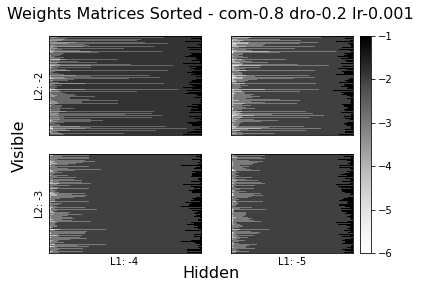

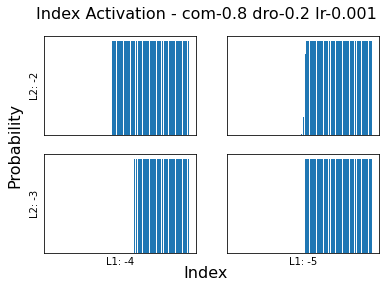

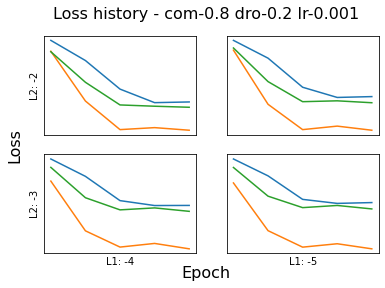

In [276]:
def test_model_reg_cof(trainingSet, order_variation, epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.001, 0.01], dropout = 0.2, lr = 0.001, validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError(), weight_sort="unit"):
    param_name = "- com-"+str(compression)+" dro-"+str(dropout)+ " lr-"+str(lr)
    
    fig_sorted, axes_sorted = plt.subplots(nrows=order_variation, ncols=order_variation)
    fig_sorted.suptitle('Weights Matrices Sorted '+param_name, fontsize=16)
    fig_sorted.subplots_adjust(hspace = .2, wspace = 0.2)

    fig_index, axes_index = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_index.suptitle("Index Activation "+param_name, fontsize = 16)

    fig_loss, axes_loss = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_loss.suptitle("Loss history "+param_name, fontsize = 16)
    im = None
    im2=None
    for i in range(order_variation):

        for j in range(order_variation):
            model, model_history = train_model(
                trainingSet, epochs, 
                compression, batch_size, [reg_cof[0] / 10**i, reg_cof[1] / 10**j], 
                dropout, lr, validation_split, metrics)

            #bit_activation, weights_matrix, sorted_weights_matrix = weights_matrix_sorting(model)
            if weight_sort=="unit":
                bit_activation, weights_matrix, sort_matrix = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(sort_matrix,interpolation='nearest',cmap=cm.Greys)

            if weight_sort=="split":
                bit_activation, weights_matrix, mask_neg, mask_pos, neg, pos = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(mask_neg,interpolation='nearest',cmap=cm.Blues)
                im2 = axes_sorted[i][j].imshow(mask_pos,interpolation='nearest',cmap=cm.Reds)

            axes_sorted[i][j].set_aspect('auto')
            axes_sorted[i][j].xaxis.set_ticks([])
            axes_sorted[i][j].yaxis.set_ticks([])

            axes_index[i][j].bar(np.arange(len(bit_activation)), bit_activation)
            axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_index[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_loss[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)

                
        axes_sorted[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
        axes_index[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
        axes_loss[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
    if weight_sort=="unit":
        
        fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
    if weight_sort=="split":
        
        cbpos = fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
        cbneg = fig_sorted.colorbar(im2, ax=axes_sorted[:, order_variation-1])



        #plt.setp(axes_sorted[:,i], ylabel = "L1 {}".format(int(math.log(reg_cof[0] / 10**i,10)-1)))
    fig_sorted.text(0.5, 0.04, 'Hidden', ha='center', fontsize = 16)
    fig_sorted.text(0.04, 0.5, 'Visible', va='center', rotation='vertical', fontsize = 16)
    
    fig_index.text(0.5, 0.04, 'Index', ha='center', fontsize = 16)
    fig_index.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize = 16)
    
    fig_loss.text(0.5, 0.04, 'Epoch', ha='center', fontsize = 16)
    fig_loss.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize = 16)

    fig_sorted.savefig(utg.create_plot_path("Weights Sorted Comparision{}.png".format(param_name)))
    fig_index.savefig(utg.create_plot_path("Index Sorted Comparision{}.png".format(param_name)))
    fig_loss.savefig(utg.create_plot_path("Loss History Comparision{}.png".format(param_name)))

    plt.show()

test_model_reg_cof(tmptrain, 2, epochs = 5, weight_sort="unit")



[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


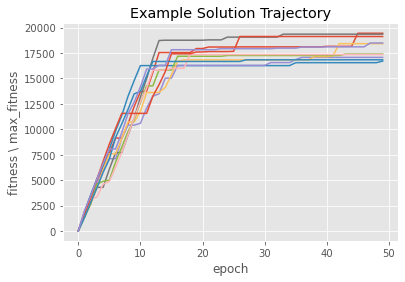

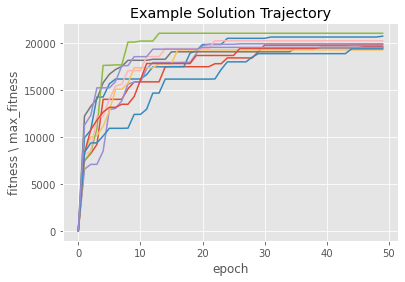

In [5]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50 ,"to_delete.png")
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model1 )

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


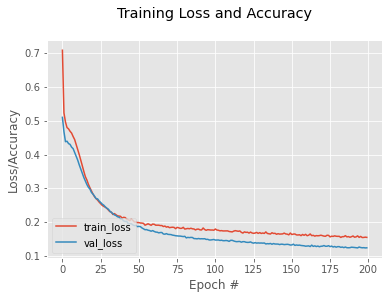

In [15]:

model2 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H2 = model2.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H2, "to_delete.png", epochs)

In [16]:
model3 = utm.add_layer_to_model(model2, compression, dropout, reg_cof,lr,True )

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_4 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 100)               818

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


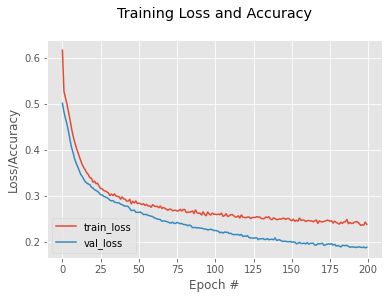

In [17]:
H3 = model3.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H3, "to_delete.png", epochs)

[INFO]: number of convoluted layers is equal to:  2
[INFO]: Weights of model were saved in the directory:  saved_plots\to_delete.png


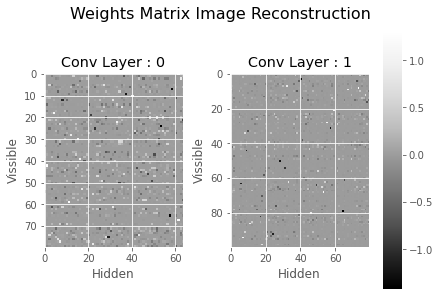

In [18]:
utp.plot_weights_model(model3, "to_delete.png")


[INFO]: Evolution model plot was saved in the directory:  saved_plots\to_delte.png


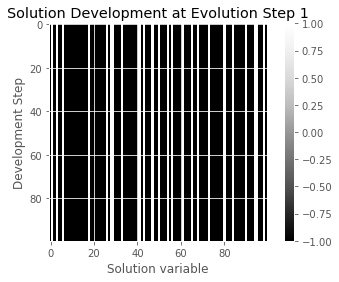

In [31]:
utp.plot_evolution_model(model3, trainY1, "to_delte.png", learning_steps=100)

[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png


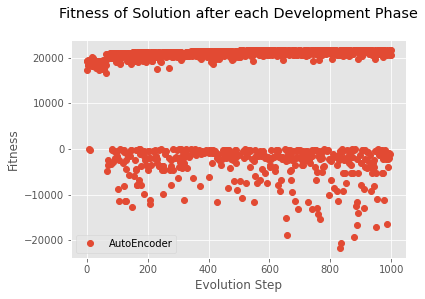

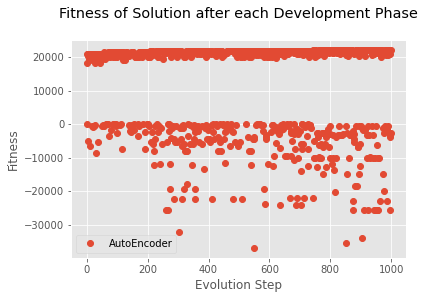

In [20]:
utp.plot_fitness_development_phase(model1, trainY1, "to_delete.png")
utp.plot_fitness_development_phase(model3, trainY1, "to_delete.png")

[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


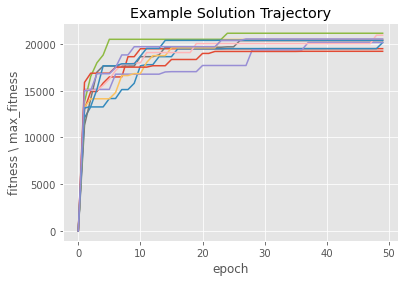

In [23]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model3 )

In [32]:
modeltmp = utg.load_models(3)[0]

In [35]:
#utp.plot_weights_model(modeltmp, "to_delete.png")
np.shape(modeltmp.layers[-1].get_weights()[1])

(100, 80)

In [36]:
modeltmp.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 100)               8180

In [213]:
arr = np.array([-0.1, 0.001,-0.001, 0.1])

def matrix_row_sort(x):
    def pushZerosToEnd(arr): 
        count = 0 # Count of non-zero elements 
        n = len(arr)
        for i in range(n): 
            if arr[i] != 0: 
                arr[count] = arr[i] 
                count+=1

        while count < n: 
            arr[count] = 0
            count += 1
        return arr
    
    def pushZerosToBegining(arr): 
        count = 0 # Count of non-zero elements 
        tmp = []
        count_zeros =0
        for i in arr.tolist(): 
            if i != 0: 
                tmp.append(i)
            else:
                count_zeros+=1
        return np.concatenate((np.zeros(count_zeros), np.asarray(tmp)), axis = None)
    pos = []
    neg = []
    for i in x:
        if i>0:
            pos.append(round(math.log(i,10)))
            neg.append(0)
        else:
            neg.append(round(math.log(-i,10)))
            pos.append(0)
    return pushZerosToEnd(-np.sort(-np.asarray(neg))), pushZerosToBegining(np.sort(np.asarray(pos)))
matrix_row_sort(arr)

(array([-1, -3,  0,  0]), array([ 0.,  0., -3., -1.]))

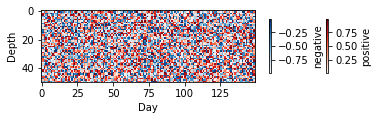

masked_array(
  data=[[0.7323806941614195, 0.4528978363832279, --, ..., --, --, --],
        [--, --, --, ..., --, 0.5569275944515162, 0.6746960234954373],
        [0.5322079230309231, 0.8206470033154245, 0.5443411179418169, ...,
         0.5679450018565666, --, 0.7799216623430807],
        ...,
        [0.9357578859068183, --, 0.3304484486132069, ..., --, --,
         0.9611600196454786],
        [--, 0.2626391297899797, 0.49089214230737666, ..., --, --,
         0.703404817801816],
        [--, --, --, ..., 0.4709529071744083, 0.33703126187079446,
         0.9775875358211044]],
  mask=[[False, False,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        ...,
        [False,  True, False, ...,  True,  True, False],
        [ True, False, False, ...,  True,  True, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)

In [134]:
tgp

array([2, 0, 0, 0])

In [124]:
arr = np.array([-2,  0,  0,  1])

    
pushZerosToBegining(arr)

array([ 0.,  0., -2.,  1.])